In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import ast
import re

In [ ]:
# Import Data from CSV
df=pd.read_csv(gsearch_jobs.csv")
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Unnamed: 0                 0
index                      0
title                      0
company_name               0
location                  37
via                        9
description                0
extensions                 0
job_id                     0
thumbnail              23759
posted_at                190
schedule_type            246
work_from_home         33973
salary                 51865
search_term                0
date_time                  0
search_location            0
commute_time           61953
salary_pay             51865
salary_rate            51865
salary_avg             51865
salary_min             52441
salary_max             52441
salary_hourly          56053
salary_yearly          57884
salary_standardized    51865
description_tokens         0
dtype: int64


In [6]:
# Drop columns with more than 95% missing values
columns_to_drop = [col for col in df.columns if df[col].isnull().mean() > 0.95]
df.drop(columns=columns_to_drop, inplace=True)
print("Dropped columns:", columns_to_drop)

df['title'] = df['title'].str.replace(r'[^\w\s]', '', regex=True).str.title()
df['company_name'] = df['company_name'].str.strip().str.replace(r'[^\w\s-]', '', regex=True)
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')


Dropped columns: ['commute_time']


In [7]:
# Clean salary ranges

salary_columns = [ 'salary', 'salary_pay', 'salary_rate']
for col in salary_columns:
    if col in df.columns:
        df[col] = (
            df[col].astype(str)
            .str.replace(r'[â€“–]', '-', regex=True) 
            .str.replace(r'[,$ ]', '', regex=True)   
        )
        
print(df[['salary', 'salary_pay', 'salary_rate']].head(10))


           salary salary_pay salary_rate
0  101K-143Kayear  101K-143K       ayear
1             nan        nan         nan
2             nan        nan         nan
3     15-25anhour      15-25      anhour
4   90K-110Kayear   90K-110K       ayear
5             nan        nan         nan
6             nan        nan         nan
7             nan        nan         nan
8             nan        nan         nan
9             nan        nan         nan


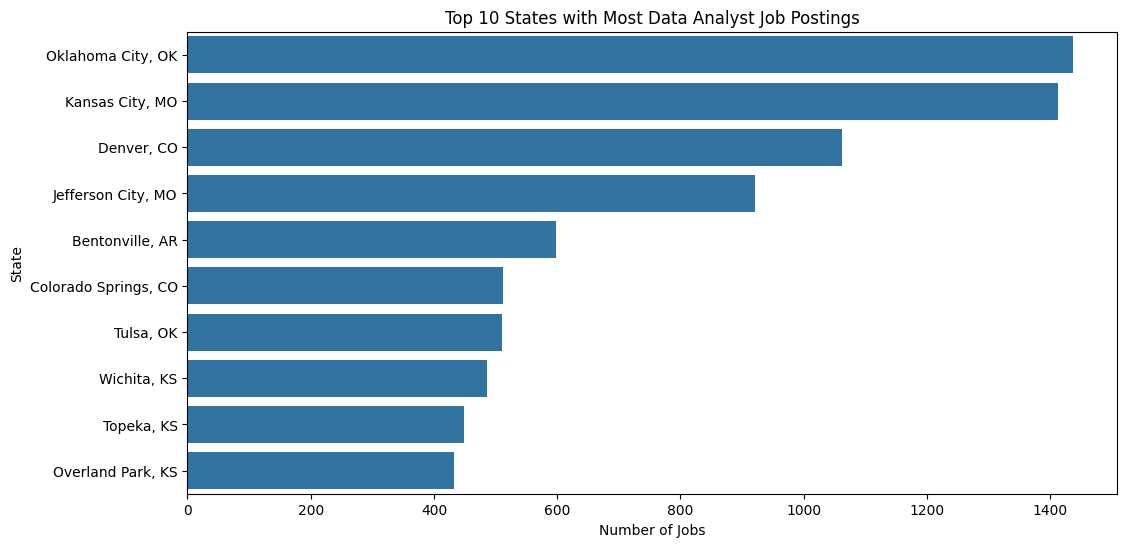

In [9]:
# Top 10 states with most job postings

df['location'] = df['location'].str.strip()
excluded_locations = ['Anywhere', 'United States']
filtered_locations = df[~df['location'].isin(excluded_locations)]['location']
top_states= filtered_locations.value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_states.values, y=top_states.index)
plt.title("Top 10 States with Most Data Analyst Job Postings")
plt.xlabel("Number of Jobs")
plt.ylabel("State")
plt.show()

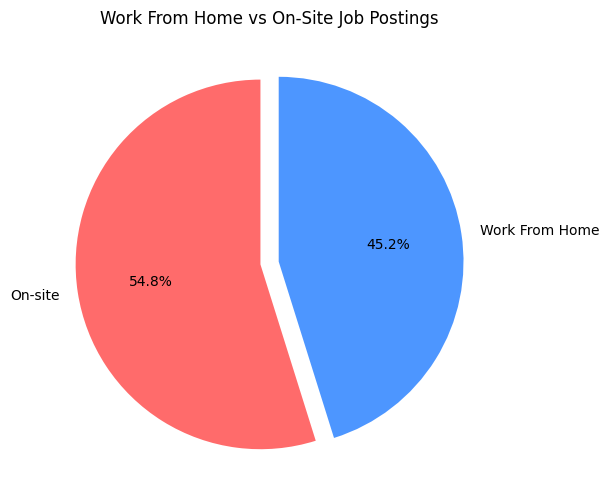

In [4]:
# Remote Work Availability
  
df['work_from_home'] = df['work_from_home'].fillna(False)
wfh_counts = df['work_from_home'].value_counts()
labels = ['On-site', 'Work From Home']
sizes = [wfh_counts[False], wfh_counts[True]]
colors = ['#FF6B6B', '#4D96FF'] 

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05))
plt.title('Work From Home vs On-Site Job Postings')
plt.show()


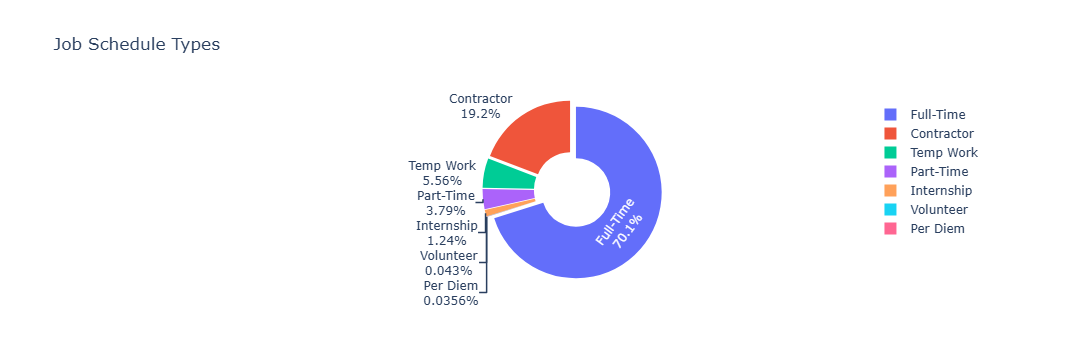

In [11]:
# Job Schedule Types

count_df = df['schedule_type'].value_counts().reset_index()
count_df.columns = ['Schedule Type', 'Count']

def categorize(schedule):
    s = schedule.lower()
    tags = []
    if 'full-time' in s: tags.append('Full-Time')
    if 'part-time' in s: tags.append('Part-Time')
    if 'contractor' in s: tags.append('Contractor')
    if 'internship' in s: tags.append('Internship')
    if 'temp work' in s: tags.append('Temp Work')
    if 'volunteer' in s: tags.append('Volunteer')
    if 'per diem' in s: tags.append('Per Diem')
    return tags or ['Other']

count_df['Category'] = count_df['Schedule Type'].apply(categorize)
exploded = count_df.explode('Category')
agg = exploded.groupby('Category', as_index=False)['Count'].sum()

fig = px.pie(agg, names='Category', values='Count',
             title='Job Schedule Types',
             hole=0.4)
fig.update_traces(textinfo='percent+label', pull=[0.05]*len(agg))
fig.update_layout(showlegend=True)
fig.show()

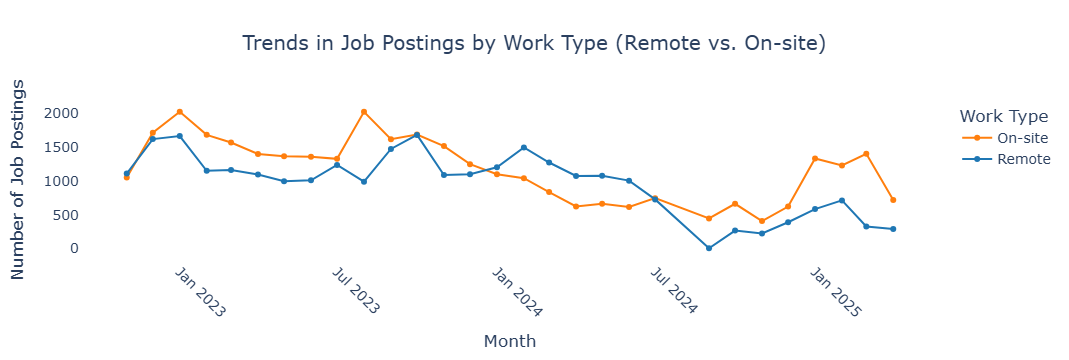

In [5]:
# Trends in Job Postings by Work Type (Remote vs. On-site)

df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
df = df.dropna(subset=['date_time'])
df['work_from_home'] = df['work_from_home'].fillna(False).astype(bool)
df['Work Type'] = df['work_from_home'].map({True: 'Remote', False: 'On-site'})
df['YearMonth'] = df['date_time'].dt.to_period('M').astype(str)

monthly_trends = df.groupby(['YearMonth', 'Work Type']).size().reset_index(name='Postings')

fig = px.line(
    monthly_trends,
    x='YearMonth',
    y='Postings',
    color='Work Type',
    markers=True,
    title='Trends in Job Postings by Work Type (Remote vs. On-site)',
    color_discrete_map={'Remote': '#1f77b4', 'On-site': '#ff7f0e'}
)

fig.update_layout(
    title_x=0.5,
    xaxis_title='Month',
    yaxis_title='Number of Job Postings',
    font=dict(size=14),
    plot_bgcolor='white'
)

fig.update_xaxes(tickangle=45)
fig.show()


C:\Users\Abenezer\AppData\Local\Temp\ipykernel_8248\1283406239.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




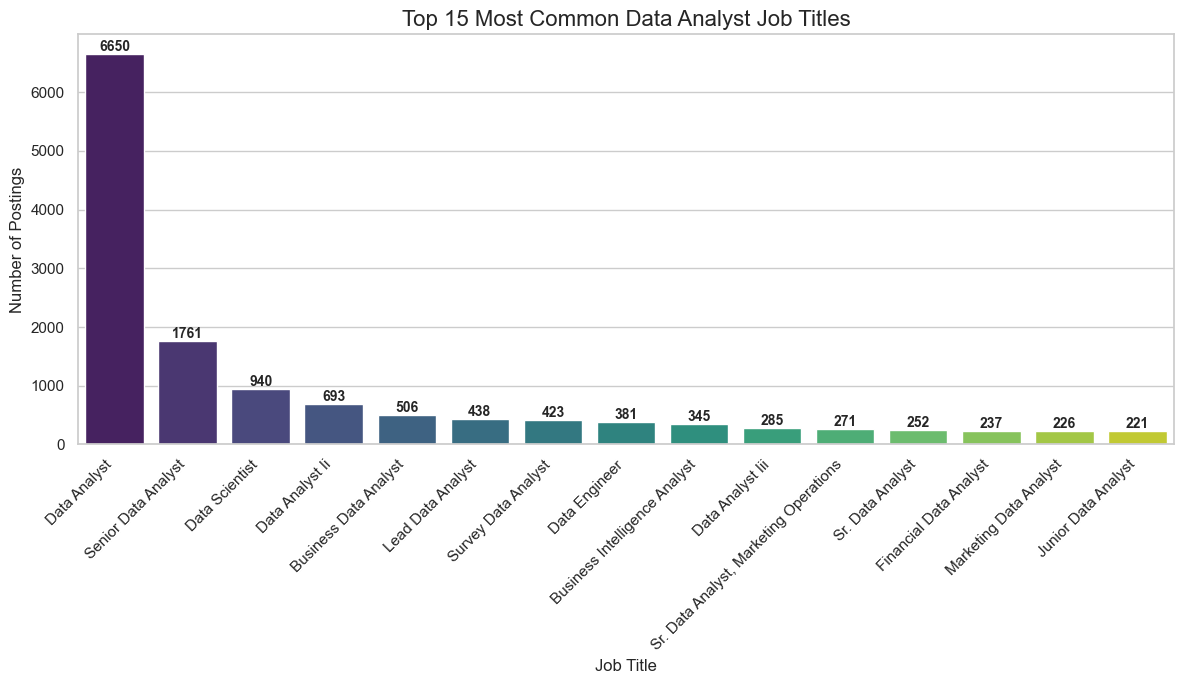

In [6]:
# 'Top 15 Most Common Data Analyst Job Titles

df['title'] = df['title'].astype(str).str.strip().str.title()
top_titles = df['title'].value_counts().nlargest(15).reset_index()
top_titles.columns = ['Job Title', 'Count']
sns.set(style='whitegrid')

plt.figure(figsize=(12, 7))
barplot = sns.barplot(data=top_titles, x='Job Title', y='Count', palette='viridis')

# Annotate bars
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
    
plt.title('Top 15 Most Common Data Analyst Job Titles', fontsize=16)
plt.xlabel('Job Title')
plt.ylabel('Number of Postings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

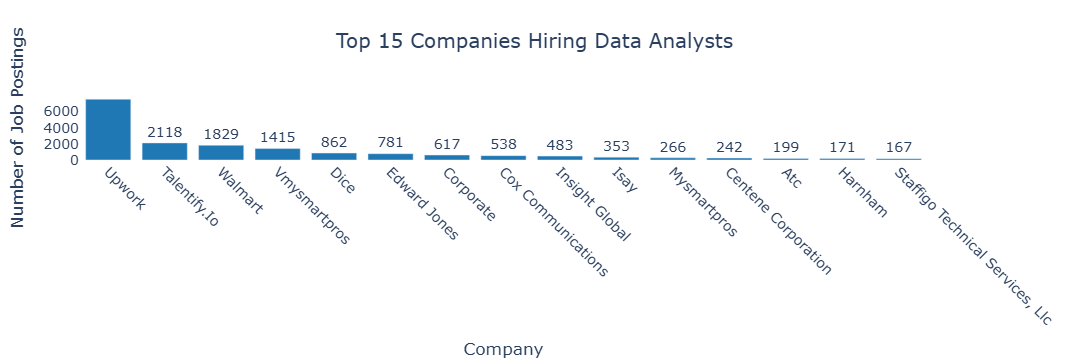

In [9]:
# Top 15 Companies Hiring Data Analysts

df['company_name'] = df['company_name'].astype(str).str.strip().str.title()

top_companies = df['company_name'].value_counts().nlargest(15).reset_index()
top_companies.columns = ['Company', 'Postings']

fig = px.bar(top_companies, x='Company', y='Postings',
             title='Top 15 Companies Hiring Data Analysts',
             text='Postings',
             color_discrete_sequence=['#1f77b4']) 

fig.update_layout(
    xaxis_title='Company',
    yaxis_title='Number of Job Postings',
    xaxis_tickangle=45,
    plot_bgcolor='white',
    font=dict(size=14),
    title_x=0.5
)

fig.update_traces(textposition='outside')
fig.show()

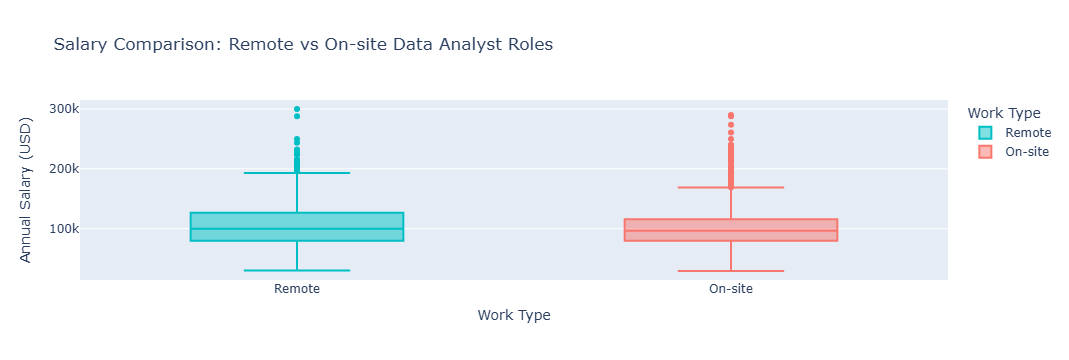

In [16]:
# Remote vs On-site Data Analyst Roles

df['salary_yearly'] = pd.to_numeric(df['salary_yearly'], errors='coerce')
df['work_from_home'] = df['work_from_home'].fillna(False).astype(bool)
df = df.dropna(subset=['salary_yearly'])
df = df[df['salary_yearly'] < 400000]
df['Work Type'] = df['work_from_home'].map({True: 'Remote', False: 'On-site'})

fig = px.box(df, x='Work Type', y='salary_yearly',
             title='Salary Comparison: Remote vs On-site Data Analyst Roles',
             labels={'salary_yearly': 'Annual Salary (USD)'},
             color='Work Type',
             color_discrete_map={'Remote': '#00BFC4', 'On-site': '#F8766D'})

fig.update_layout(yaxis_title='Annual Salary (USD)', xaxis_title='Work Type')
fig.show()


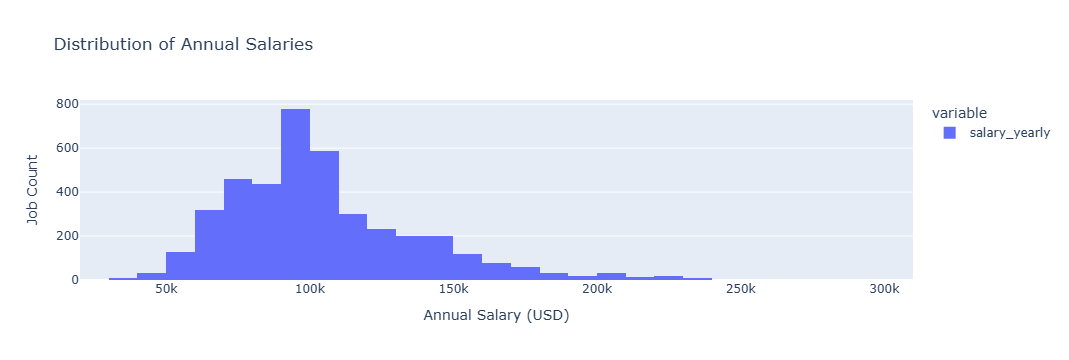

In [17]:
# Distribution of Annual Salaries

df['salary_yearly'] = pd.to_numeric(df['salary_yearly'], errors='coerce')
salary_data = df['salary_yearly'].dropna()
salary_data = salary_data[salary_data < 400000]  # Optional: remove outliers

fig = px.histogram(salary_data, nbins=50,
                   title='Distribution of Annual Salaries',
                   labels={'value': 'Annual Salary (USD)'},
                   color_discrete_sequence=['#636EFA'])

fig.update_layout(xaxis_title='Annual Salary (USD)', yaxis_title='Job Count')
fig.show()

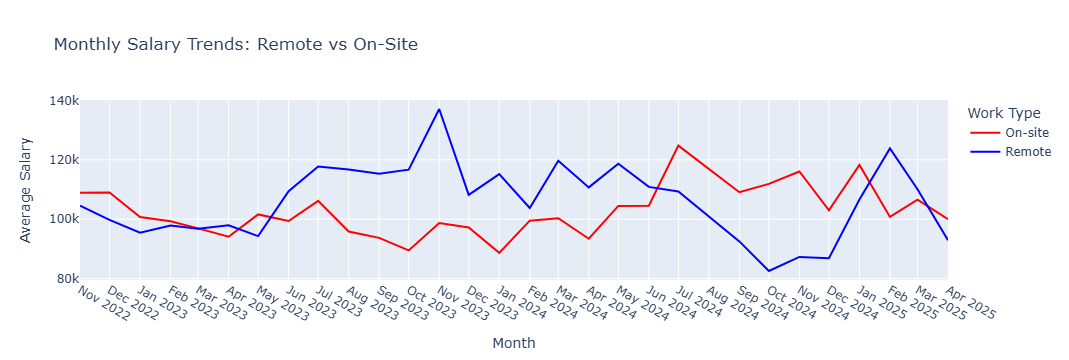

In [20]:
 # Salary Trends: Remote vs On-Site

df['date_time'] = pd.to_datetime(df['date_time'])
df['year_month'] = df['date_time'].dt.to_period('M').dt.to_timestamp()
df['work_type'] = df['work_from_home'].apply(lambda x: 'Remote' if x == True else 'On-site')
monthly_avg = df.groupby(['year_month', 'work_type'])['salary_standardized'].mean().reset_index()

fig = px.line(
    monthly_avg,
    x='year_month',
    y='salary_standardized',
    color='work_type',
    title='Monthly Salary Trends: Remote vs On-Site',
    labels={'salary_standardized': 'Average Salary', 'year_month': 'Month'},
    color_discrete_map={'Remote': 'blue', 'On-site': 'red'}
)
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Average Salary',
    legend_title='Work Type',
    hovermode='x unified'
)
fig.update_xaxes(dtick='M1', tickformat='%b %Y')
fig.show()


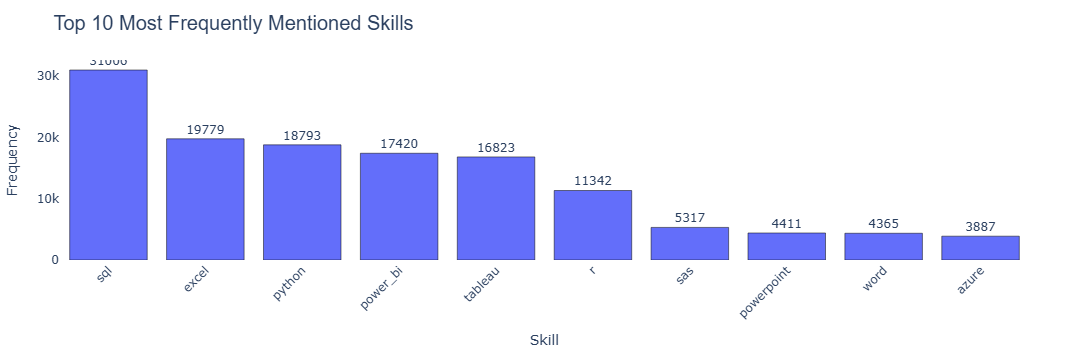

In [8]:
# Top 10 Most Frequently Mentioned Skills

df['description_tokens'] = df['description_tokens'].dropna().apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
all_tokens = [token.lower() for tokens in df['description_tokens'] for token in tokens]

token_counts = Counter(all_tokens)
top_skills = pd.DataFrame(token_counts.most_common(10), columns=['Skill', 'Frequency'])

fig = px.bar(top_skills,
             x='Skill',
             y='Frequency',
             title='Top 10 Most Frequently Mentioned Skills',
             text='Frequency',
             color_discrete_sequence=['#636EFA'])  

fig.update_traces(marker_line_color='black', marker_line_width=0.5, textposition='outside')
fig.update_layout(
    title_font=dict(size=20, family='Arial'),
    xaxis_title='Skill',
    yaxis_title='Frequency',
    xaxis_tickangle=-45,
    plot_bgcolor='white',
    showlegend=False,
    margin=dict(l=40, r=40, t=60, b=100)
)
fig.show()
